In [318]:
import pandas as pandas
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import string
import re
import nltk
from nltk.corpus import stopwords
import itertools as itertools

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2596 entries, 0 to 2595
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   myId        2596 non-null   int64 
 1   id          2596 non-null   int64 
 2   filename    2596 non-null   object
 3   title       1301 non-null   object
 4   text        2596 non-null   object
 5   label_text  2596 non-null   object
 6   label       2596 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 142.1+ KB


0    Fake
1    Real
2    Real
3    Fake
4    Fake
Name: label_text, dtype: object

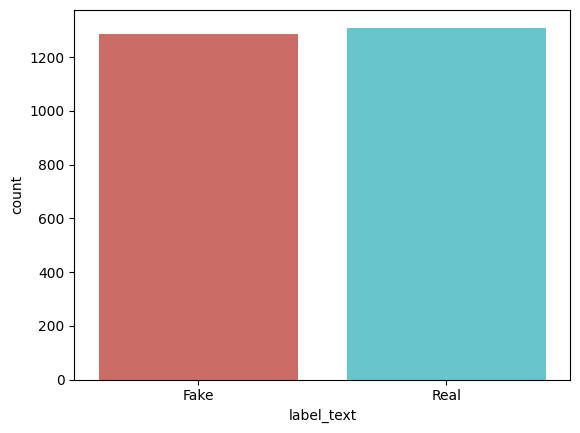

In [319]:
df=pandas.read_csv('Final13022.csv',encoding='windows-1252')

df.shape

import seaborn as sb
def create_distribution(datafile):
    return sb.countplot(x='label_text',data =datafile, palette ='hls')
create_distribution(df)

def data_qualityCheck():
    df.isnull().sum()
    df.info()
    
data_qualityCheck()    

y=df.label_text
y.head()

In [320]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test=train_test_split(df['text'],y,test_size=0.20,random_state=9)

y_test.head(10)

X_train.head(10)

211     In our previous analysis we warned traders tha...
2460    You can maintain the alkaline state of the bod...
846     There is no need for the public to wear surgic...
1022    Under the category, the more things change, th...
2235    Why you should not take seriously this card on...
2591    Vitamin C with Zinc prevent and treat the coro...
1468    Most quarantine decisions are up to states and...
1905    It occurs to me that the world wide death rare...
2419    The Simpsons have predicted the coronavirus pa...
1837    A midshipman at the U.S. Naval Academy in Anna...
Name: text, dtype: object

In [321]:
# Define a function to filter out non-English or gibberish words
def filter_non_english(text):
    english_word_pattern = re.compile(r'\b[a-zA-Z]+\b')
    english_words = english_word_pattern.findall(text)
    filtered_text = ' '.join(english_words)
    return filtered_text

# Filter the corpus to remove non-English or gibberish words
filtered_corpus = [filter_non_english(text) for text in X_train]

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def clean_data(text):
    cleaned_corpus =[]
    for tt in text:
        cleaned_text =re.sub(r'[^\w\s]', '', tt.strip())#remove punctuation
        cleaned_text=re.sub('\n','',cleaned_text) #Remove New lines
        cleaned_text=re.sub(r"http\S+", "", cleaned_text) #to remove urls
        cleaned_text = re.sub(r'\b\d+/\d+\b', '', cleaned_text)#remove numbers
        cleaned_text = cleaned_text.lower()
        cleaned_text = remove_stopwords(cleaned_text)
        cleaned_corpus.append(cleaned_text)
    return cleaned_corpus       

CleanedCorpus = clean_data(filtered_corpus)

In [322]:
tokenized_corpus = []   
for sentence in CleanedCorpus:
    tokens = nltk.word_tokenize(sentence)
    tokenized_corpus.append(tokens)
#len(tokenized_corpus)
joined_tokens = [' '.join(tokens) for tokens in tokenized_corpus]


2076

In [323]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b[^\d\s]+\b',stop_words = 'english', max_df = 0.8)
tfidf_train = tfidf_vectorizer.fit_transform(joined_tokens)

def get_tfidf_stats():
    tfidf_train.shape
    print(tfidf_train.A[:10])
get_tfidf_stats()

#get the extracted features
print(tfidf_vectorizer.get_feature_names_out()[-10:])

tfidf_df = pandas.DataFrame(tfidf_train.A,columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['zoos' 'zs' 'zte' 'zuckerberg' 'zulfikar' 'zulu' 'zuo' 'zureikat'
 'zverev' 'zweli']
    aa  aaa  aadmi  aahuja  aai  aajtak  aameen  aana  aangirfan  aanirfan  \
0  0.0  0.0    0.0     0.0  0.0     0.0     0.0   0.0        0.0       0.0   
1  0.0  0.0    0.0     0.0  0.0     0.0     0.0   0.0        0.0       0.0   
2  0.0  0.0    0.0     0.0  0.0     0.0     0.0   0.0        0.0       0.0   
3  0.0  0.0    0.0     0.0  0.0     0.0     0.0   0.0        0.0       0.0   
4  0.0  0.0    0.0     0.0  0.0     0.0     0.0   0.0        0.0       0.0   

   ...  zoos   zs  zte  zuckerberg  zulfikar  zulu  zuo  zureikat  zverev  \
0  ...   0.0  0.0  0.0         0.0       0.0   0.0  0.0       0.0     0.0   
1  ...   0.0  0.0  0.0         0.0       0.0   0.0  0.0       0.0     0.0   
2  ...   0.0  0.0  0.0         0.0       0.0   0.0  0.0   

In [324]:
#builing naive classifier model
nb_pipeline = Pipeline([('NBTV',tfidf_vectorizer),('nb_clf', MultinomialNB())])
nb_pipeline.fit(joined_tokens, y_train)

Pipeline(steps=[('NBTV',
                 TfidfVectorizer(max_df=0.8, stop_words='english',
                                 token_pattern='\\b[^\\d\\s]+\\b')),
                ('nb_clf', MultinomialNB())])

In [325]:
#Test data
filtered_Testcorpus = [filter_non_english(text) for text in X_test]
CleanedTestDate = clean_data(filtered_Testcorpus)    
tokenized_corpus_test = []   
for sentence in CleanedTestDate:
    tokens = nltk.word_tokenize(sentence)
    tokenized_corpus_test.append(tokens)

joined_tokens_test = [' '.join(tokens) for tokens in tokenized_corpus_test]
    
tfidf_test = tfidf_vectorizer.transform(joined_tokens_test)
tfidf_test

tfidf_test_df=pandas.DataFrame(tfidf_test.A,columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df.head()

,aa,aaa,aadmi,aahuja,aai,aajtak,aameen,aana,aangirfan,aanirfan,...,zoos,zs,zte,zuckerberg,zulfikar,zulu,zuo,zureikat,zverev,zweli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [326]:
#test vector
predicted_nbt = nb_pipeline.predict(joined_tokens_test)
score = metrics.accuracy_score(y_test,predicted_nbt)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 75.19%


In [327]:
cm = metrics.confusion_matrix(y_test.to_numpy(),predicted_nbt,labels=['Fake','Real'])
cm

array([[146, 101],
       [ 28, 245]], dtype=int64)

Confusion matrix without normalization


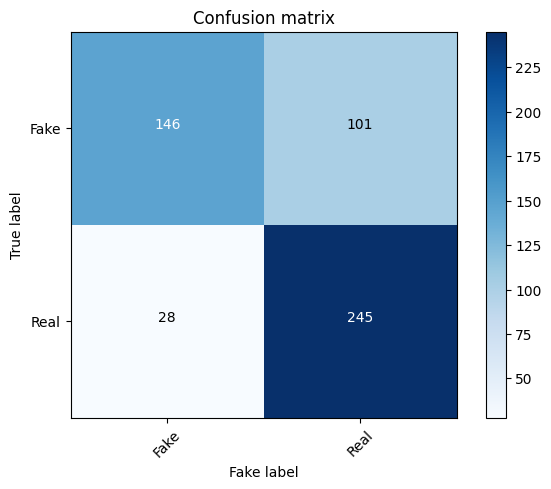

In [328]:
#plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
    
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment = "center",
                color= "white" if cm[i,j]>thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Fake label')
    

plot_confusion_matrix(cm,classes=['Fake','Real'])

In [329]:
print(metrics.classification_report(y_test,predicted_nbt))

              precision    recall  f1-score   support

        Fake       0.84      0.59      0.69       247
        Real       0.71      0.90      0.79       273

    accuracy                           0.75       520
   macro avg       0.77      0.74      0.74       520
weighted avg       0.77      0.75      0.75       520

